In [73]:
import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import numpy as np
from collections import defaultdict


num_class = 256
data_dir = '../256_ObjectCategories/'

In [74]:
def list_gen(data_dir):
    """
    generating lists of all images in each class
    :return: dict{"class_id": [image_paths]}
    """
    image_dirs = glob.glob(data_dir + '*')
    d = defaultdict(list)
    for idir in image_dirs:
        all_images = glob.glob(idir + '/*.jpg')
        label_id = int(idir.split('/')[-1].split('.')[0])-1
        if label_id > 255:
            continue
        np.random.shuffle(all_images)
        train_paths, val_paths, test_paths = all_images[:len(all_images)/10*8], all_images[len(all_images)/10*8:len(all_images)/10*9], all_images[len(all_images)/10*9:]
        train_labels, val_labels, test_labels = [label_id]*(len(all_images)/10*8), [label_id]*(len(all_images)/10), [label_id]*(len(all_images)/10)
        
        d['train_images'].append(train_paths)
        d['val_images'].append(val_paths)
        d['test_images'].append(test_paths)
        d['train_labels'].append(train_labels)
        d['val_labels'].append(val_labels)
        d['test_labels'].append(test_labels)
    return d

all_d = list_gen(data_dir)

In [75]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras.applications.imagenet_utils import preprocess_input

def load_data(image_paths, labels, crop_size):
    """
    Given list of paths, load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
    :return X: image array
    "return y: one hot encoded labels
    """
    X = np.zeros((len(image_paths), crop_size, crop_size, 3))
    for i,path in enumerate(image_paths):
        X[i, :] = img_to_array(load_img(path, target_size=(crop_size, crop_size)))
    y = np_utils.to_categorical(labels)
    return X, y

crop_size = 224
all_per_class = 16
train_paths = []
val_paths = []
test_paths = []
train_labels = []
val_labels = []
test_labels = []
for i in xrange(num_class):
    train_paths += (all_d['train_images'][i][:all_per_class])
    val_paths += (all_d['val_images'][i][:all_per_class])
    test_paths += (all_d['test_images'][i][:all_per_class])
    train_labels += (all_d['train_labels'][i][:all_per_class])
    val_labels += (all_d['val_labels'][i][:all_per_class])
    test_labels += (all_d['test_labels'][i][:all_per_class])

X_train, y_train = load_data(train_paths, train_labels, crop_size)
X_val, y_val = load_data(val_paths, val_labels, crop_size)
X_test, y_test = load_data(test_paths, test_labels, crop_size)

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [76]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    rescale=1./128)

datagen.fit(X_train)  # nothing to fit in fact...

In [77]:
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializations import normal


def getModel( output_dim ):
    ''' 
    Model definition
    :param output_dim: the number of classes (int)
    :return compiled model (keras.engine.training.Model)
    '''
    vgg_model = VGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.layers[-2].output #Last FC layer's output  
    softmax_layer = Dense(output_dim, activation='softmax')(vgg_out) #Create softmax layer taking input as vgg_out
    #Create new transfer learning model
    tl_model = Model( input=vgg_model.input, output=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers:
        layer.trainable = False
    return tl_model

# model = getModel(num_class)
# model.summary()

In [78]:
# Model compiling
model = getModel(num_class)
# sgd = SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)  # Slow
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    samples_per_epoch=len(X_train), nb_epoch=10)

Epoch 1/10
1664/4096 [===========>..................] - ETA: 18s - loss: 7.9187 - acc: 0.0114

KeyboardInterrupt: 

In [9]:
# training 
num_epoch = 50
batch_size = 64

for sample_per_class in [2,4,8,16]:
    train = X_train.reshape((num_class, -1, crop_size, crop_size, 3))
    train = train[:, :sample_per_class].reshape((-1, crop_size, crop_size, 3))
    label = y_train.reshape((num_class, -1, num_class))
    label = label[:, :sample_per_class].reshape((-1, num_class))
    rmsmodel = getModel(num_class)
    rmsmodel.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    rmsmodel.fit_generator(datagen.flow(train, label, batch_size=32),
                           validation_data=datagen.flow(X_val, y_val, batch_size=batch_size),
                           nb_val_samples=200,
                           samples_per_epoch=len(train), nb_epoch=num_epoch)

Epoch 1/50
512/512 [==============================] - 6s - loss: 10.2884 - acc: 0.0020 - val_loss: 7.5286 - val_acc: 0.0039
Epoch 2/50
512/512 [==============================] - 6s - loss: 6.5496 - acc: 0.0137 - val_loss: 6.1474 - val_acc: 0.0078
Epoch 3/50
512/512 [==============================] - 6s - loss: 5.7005 - acc: 0.0215 - val_loss: 5.9528 - val_acc: 0.0430
Epoch 4/50
512/512 [==============================] - 6s - loss: 5.0559 - acc: 0.0391 - val_loss: 5.8071 - val_acc: 0.0391
Epoch 5/50
512/512 [==============================] - 6s - loss: 4.4553 - acc: 0.0723 - val_loss: 5.2556 - val_acc: 0.0938
Epoch 6/50
512/512 [==============================] - 6s - loss: 3.8692 - acc: 0.1270 - val_loss: 5.0214 - val_acc: 0.0781
Epoch 7/50
512/512 [==============================] - 6s - loss: 3.3450 - acc: 0.1992 - val_loss: 4.7153 - val_acc: 0.1016
Epoch 8/50
512/512 [==============================] - 7s - loss: 2.8636 - acc: 0.2676 - val_loss: 5.1866 - val_acc: 0.0820
Epoch 9/50
512/

In [32]:
# Edit the output manullay and store in the log file before runing this
train_loss=[[],[],[],[]]
val_loss=[[],[],[],[]]
train_accu=[[],[],[],[]]
val_accu=[[],[],[],[]]
with open('log', 'r') as f:  
    for i,line in enumerate(f.readlines()):
        fields = line.strip().split('\t')
        fields = fields[1:]
        idx = i/50
        train_loss[idx].append(float(fields[0].split(':')[-1]))
        train_accu[idx].append(float(fields[1].split(':')[-1]))
        val_loss[idx].append(float(fields[2].split(':')[-1]))
        val_accu[idx].append(float(fields[3].split(':')[-1]))

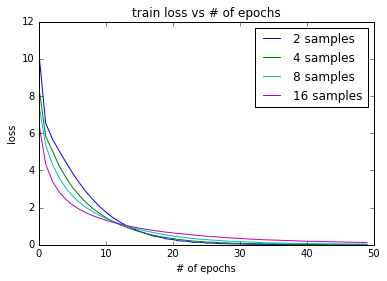

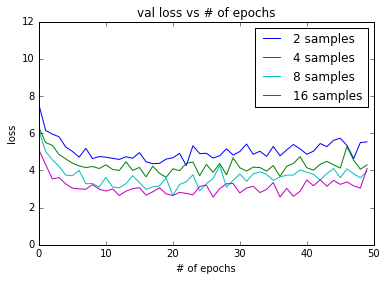

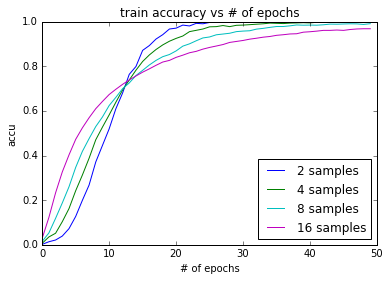

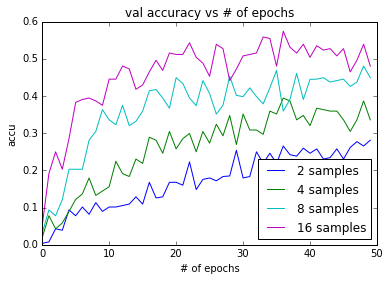

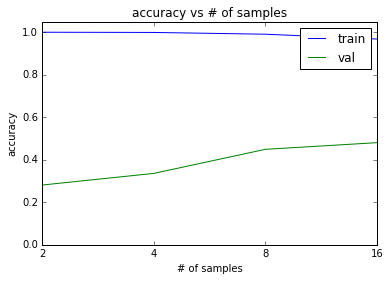

In [69]:
# plotting
c = ['b', 'g', 'c', 'm']

# train loss vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(train_loss[i])), train_loss[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
#     plt.plot(range(len(val_loss[i])), val_loss[i], '--', color=c[i], 
#              label='{} img/class val'.format(sample_size))
plt.title('train loss vs # of epochs')
ax.legend(loc='upper right')
ylim = ax.get_ylim()
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.savefig('images/4aTrain.pdf')
plt.show()

# val loss vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(val_loss[i])), val_loss[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('val loss vs # of epochs')
ax.legend(loc='upper right')
ax.set_ylim(ylim)
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.savefig('images/4aVal.pdf')
plt.show()

# train accu vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(train_accu[i])), train_accu[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('train accuracy vs # of epochs')
ax.legend(loc='lower right')
plt.xlabel('# of epochs')
plt.ylabel('accu')
plt.savefig('images/4bTrain.pdf')
plt.show()

# val accu vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(val_accu[i])), val_accu[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('val accuracy vs # of epochs')
ax.legend(loc='lower right')
plt.xlabel('# of epochs')
plt.ylabel('accu')
plt.savefig('images/4bVal.pdf')
plt.show()

# training sample vs accu
plt.figure()
plt.plot(range(4), [train_accu[i][-1] for i in xrange(4)], label='train')
plt.plot(range(4), [val_accu[i][-1] for i in xrange(4)], label='val')
plt.xticks(range(4), ['2','4','8','16'])
plt.title('accuracy vs # of samples')
plt.legend(loc='lower right')
plt.ylim([0,1.05])
plt.xlabel('# of samples')
plt.ylabel('accuracy')
plt.savefig('images/4c.pdf')
plt.show()
